In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Regressors
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import KFold, cross_val_score
import optuna

 <h3><b>Reading Train and Test datasets</b></h3>

In [3]:
train = pd.read_csv("Dataset/train_v9rqX0R.csv")
test = pd.read_csv("Dataset/test_AbJTz2l.csv")

<h3><b>Reading the prepared datasets after performing EDA and data preparation</b></h3>

In [4]:
train_prepared = pd.read_csv("train_encoded.csv")
test_prepared= pd.read_csv("test_encoded.csv")

In [5]:
train_prepared.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,1999,1,0,1,3735.1380
1,DRC01,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2009,1,2,2,443.4228
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,1999,1,0,1,2097.2700
3,FDX07,19.20,1,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,2,2,0,732.3800
4,NCD19,8.93,0,0.000000,Household,53.8614,OUT013,1987,0,2,1,994.7052


In [6]:
test_prepared.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,0,0.007565,Snack Foods,107.8622,OUT049,1999,1,0,1
1,FDW14,8.300,1,0.038428,Dairy,87.3198,OUT017,2007,2,1,1
2,NCN55,14.600,0,0.099575,Others,241.7538,OUT010,1998,2,2,0
3,FDQ58,7.315,0,0.015388,Snack Foods,155.0340,OUT017,2007,2,1,1
4,FDY38,13.600,1,0.118599,Dairy,234.2300,OUT027,1985,1,2,3


In [7]:
X = train_prepared.drop(columns=['Item_Identifier','Item_Type','Outlet_Identifier', 'Item_Outlet_Sales'], axis=1)
Y = train_prepared['Item_Outlet_Sales']

# Print the shapes of X and Y
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (8523, 8)
Shape of Y: (8523,)


In [8]:
X_test = test_prepared.drop(columns=['Item_Identifier','Item_Type','Outlet_Identifier',])

<h3><b>Split the dataset into a train and validation set</b></h3>

In [9]:
# Split the dataset into a train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shapes of the train and validation sets
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(6818, 8) (1705, 8) (6818,) (1705,)


<h3><b>Checking the baseline models performance on the dataset</b></h3>

In [10]:
# Define a list of regressor models
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    SVR(),
    KNeighborsRegressor(),
    GaussianProcessRegressor(),
    XGBRegressor(),
    LGBMRegressor(),
    CatBoostRegressor(verbose=False)
]

# Train and evaluate each regressor model
for model in models:
    model_name = model.__class__.__name__
    print("Training and evaluating", model_name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    print("MSE:", rmse)
    print("=" * 50)

Training and evaluating LinearRegression
MSE: 1143.036105488053
Training and evaluating Ridge
MSE: 1142.8640894646364
Training and evaluating Lasso
MSE: 1142.4302543352017
Training and evaluating ElasticNet
MSE: 1200.7632974305855
Training and evaluating DecisionTreeRegressor
MSE: 1502.308313198309
Training and evaluating RandomForestRegressor
MSE: 1089.9377201044692
Training and evaluating GradientBoostingRegressor
MSE: 1029.0628197997999
Training and evaluating AdaBoostRegressor
MSE: 1127.2365326103427
Training and evaluating SVR
MSE: 1669.9263721281975
Training and evaluating KNeighborsRegressor
MSE: 1215.4195506889107
Training and evaluating GaussianProcessRegressor
MSE: 2016.1566931745435
Training and evaluating XGBRegressor
MSE: 1103.1139695350796
Training and evaluating LGBMRegressor
MSE: 1050.36357309881
Training and evaluating CatBoostRegressor
MSE: 1050.5262204286196


In [11]:
# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500, step=50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.5),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 15),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }
    
    # Create the GradientBoostingRegressor model with the current hyperparameters
    model = GradientBoostingRegressor(**params)
    
    # Perform K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = -cross_val_score(model, X, Y, cv=kf, scoring='neg_mean_squared_error')
    
    # Return the mean absolute error (MAE) as the objective value for Optuna
    return np.mean(scores)

# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run the optimization to find the best hyperparameters
study.optimize(objective, n_trials=100)

# Get the best hyperparameters and the best score
best_params = study.best_params
best_score = study.best_value

# Print the best hyperparameters and the best score
print('Best Hyperparameters:', best_params)
print('Best Score (MAE):', best_score)

[I 2023-06-25 22:48:49,094] A new study created in memory with name: no-name-82ddd5ee-5c8d-4f11-855b-0c0df82575fb


[I 2023-06-25 22:53:31,876] Trial 0 finished with value: 1594273.7658857373 and parameters: {'n_estimators': 1150, 'learning_rate': 0.14039133432851086, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 15, 'max_features': 'auto'}. Best is trial 0 with value: 1594273.7658857373.
[I 2023-06-25 22:54:06,447] Trial 1 finished with value: 1236926.9110175576 and parameters: {'n_estimators': 500, 'learning_rate': 0.026142383767952058, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 1 with value: 1236926.9110175576.
[I 2023-06-25 22:54:50,420] Trial 2 finished with value: 1809071.6126750712 and parameters: {'n_estimators': 450, 'learning_rate': 0.6714010628609463, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 1236926.9110175576.
[I 2023-06-25 22:54:57,313] Trial 3 finished with value: 2390607.3213642174 and parameters: {'n_estimators': 200, 'learning_rate': 

Best Hyperparameters: {'n_estimators': 1200, 'learning_rate': 0.004698910512926407, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'log2'}
Best Score (MAE): 1166481.5248459335


In [21]:
gbr_best = GradientBoostingRegressor( n_estimators=1200, learning_rate=0.004698910512926407, max_depth=4, min_samples_split=12, min_samples_leaf=6, max_features='log2')
gbr_best.fit(X_train,y_train)
gbr_pred = gbr_best.predict(X_val)
mse = mean_squared_error(y_val, gbr_pred)
rmse = np.sqrt(mse)
print(f"ROC AUC error:{rmse}")

ROC AUC error:1021.5243636209265


<h3><b>Analysing the model performance</b><h3>

In [22]:
importances = gbr_best.feature_importances_
feature_names= X_train.columns

for feature, importance in zip(feature_names, importances):
    print(f'{feature} : {importance}')

Item_Weight : 0.00985202445940969
Item_Fat_Content : 0.000590576502661541
Item_Visibility : 0.01645085111331703
Item_MRP : 0.5634689958842698
Outlet_Establishment_Year : 0.07866291356551147
Outlet_Size : 0.03753950661380012
Outlet_Location_Type : 0.019147023899004096
Outlet_Type : 0.2742881079620262


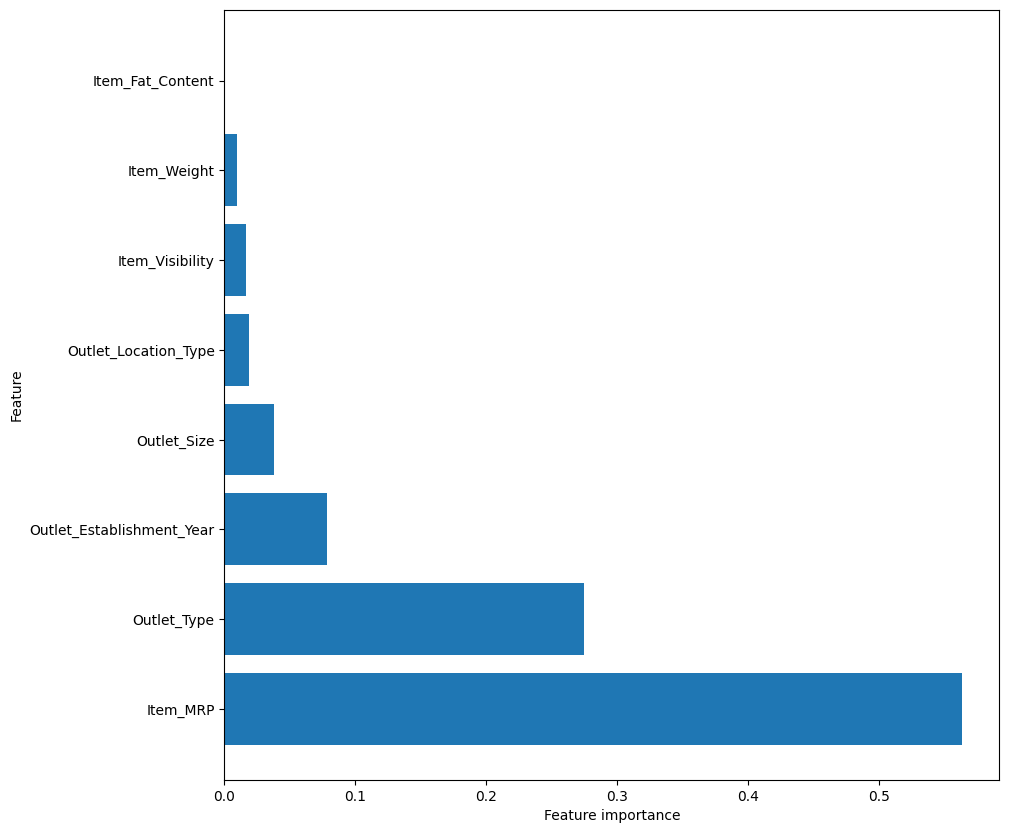

In [23]:
# Create a list of (feature, importance) tuples
feature_importances = [(feature, importance) for feature, importance in zip(feature_names, importances)]

# Sort the feature importances by importance
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Extract the feature names and importances
feature_names, importances = zip(*feature_importances)

# Plot the feature importances
plt.figure(figsize=(10,10))
plt.barh(range(len(feature_names)), importances, align='center')
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

<h3><b>Applying the lgbm with best hyperparameters on the test dataset</b></h3>

In [24]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [25]:
X_test.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,20.750,0,0.007565,107.8622,1999,1,0,1
1,8.300,1,0.038428,87.3198,2007,2,1,1
2,14.600,0,0.099575,241.7538,1998,2,2,0
3,7.315,0,0.015388,155.0340,2007,2,1,1
4,13.600,1,0.118599,234.2300,1985,1,2,3


In [26]:
pred = gbr_best.predict(X_test)
pred

array([1628.50354531, 1401.3568154 ,  599.78016456, ..., 1904.77557098,
       3674.13810356, 1341.81900493])

In [27]:
# Print the negative values predicted
negative_values = pred[pred < 0]
print("Negative values predicted:", negative_values)

Negative values predicted: [-6.94480218]


In [28]:
# Change negative values to 1
pred[pred < 0] = 1

<h3><b>Generating output csv file for submission</b></h3>

In [29]:
output = pd.DataFrame({'Item_Identifier':test.Item_Identifier, 'Outlet_Identifier':test.Outlet_Identifier, 'Item_Outlet_Sales':pred})
output.to_csv('Big_Mart_Sales_optuna.csv',index=False)
print("Your submission was successfully saved")

Your submission was successfully saved
